# Candidate class to analyse single pulses

In [1]:
import your

your.__version__

'0.6.2'

In [2]:
from your.candidate import Candidate
from your.utils.plotter import plot_h5
from scipy.signal import detrend
import os

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
%matplotlib inline

In [3]:
import pylab as plt
import logging

logger = logging.getLogger()
logger = logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(threadName)s - %(levelname)s - %(message)s",
)

## Loading the data
First, we make the candidate object with relevant parameters of the candidate. Let's download a filterbank file with an FRB signal.  

In [4]:
import tempfile
from urllib.request import urlretrieve

In [5]:
temp_dir = tempfile.TemporaryDirectory()
download_path = str(temp_dir.name) + "/FRB180417.fil"
url = "https://zenodo.org/record/3905426/files/FRB180417.fil"
urlretrieve(
    url,
    download_path,
)
fil_file = download_path

## Candidate object

To create a candidate object you would need atleast:

* Source file (PSRFITS or filterbank)
* DM (pc/cc)
* Candiate arrival time (s)
* Pulse width (samples)

This information can be obtained from the output of most single pulse search softwares. 
We used `Heimdall` to search our filterbank file. Here is one row from the output of `Heimdall`, which contains the information of our candidate: 

16.8128	1602	2.02888	1	127	475.284	22	1601	1604

Different numbers here represent the following properties of the detected transient (see [this](https://sourceforge.net/p/heimdall-astro/wiki/Use/) for more details):

snr candidate_sample_number candidate_time width dm_trial_index dm cluster_size start_sample end_sample 

Now, let's create the candidate object using some of this information:

In [6]:
cand = Candidate(
    fp=fil_file,
    dm=475.28400,
    tcand=2.0288800,
    width=2,
    label=-1,
    snr=16.8128,
    min_samp=256,
    device=0,
)

## Reading data
`get_chunk()` will extract data from the source file (filterbank file in this case), and the data can then be accessed using `cand.data`:

In [7]:
cand.get_chunk()
print(cand.data, cand.data.shape, cand.dtype)

[[124 114 143 ... 145 118 159]
 [108 158 129 ... 122 142 158]
 [122 123 131 ... 119 142 129]
 ...
 [114 113 142 ... 120 141 160]
 [120 113 103 ... 146 107 136]
 [139 133 113 ... 146 141 160]] (991, 336) <class 'numpy.uint8'>


## Dedispersion

Here is our dispersed pulse (it is too weak to see)

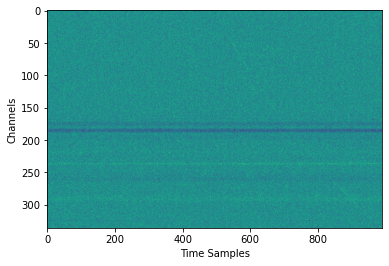

In [8]:
plt.imshow(cand.data.T, aspect="auto", interpolation=None)
plt.ylabel("Channels")
plt.xlabel("Time Samples")
plt.show()

Now let's make the DM-Time plot using the [`dmtime`](https://thepetabyteproject.github.io/your/candidate/#dmtime) method.

**!!! note** This may take a while. 

In [9]:
cand.dmtime()

Using <class 'str'>:
/tmp/tmphx0es8r_/FRB180417.fil

The DM-time data can be accessed using `cand.dmt`. Let's have a look: 

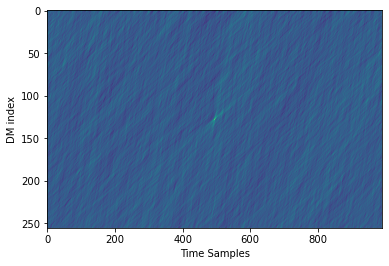

In [10]:
plt.imshow(cand.dmt, aspect="auto", interpolation=None)
plt.ylabel("DM index")
plt.xlabel("Time Samples")
plt.show()

We can see the bow-tie shape and the peak in the middle in the above plot. Now let's dedisperse the data using the [`dedisperse`](https://thepetabyteproject.github.io/your/candidate/#dedisperse) method.

In [11]:
cand.dedisperse()

Using <class 'str'>:
/tmp/tmphx0es8r_/FRB180417.fil

The dedispersed frequency-time data can be obtained using `cand.dedispersed`

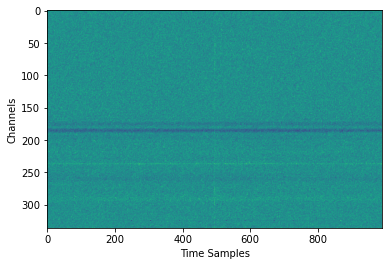

In [12]:
plt.imshow(cand.dedispersed.T, aspect="auto", interpolation=None)
plt.ylabel("Channels")
plt.xlabel("Time Samples")
plt.show()

The FRB is weakly visible in the middle of the plot. To see the FRB pulse profile let's plot the time series 

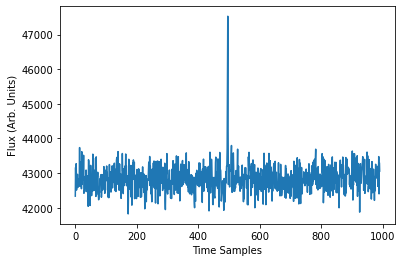

In [13]:
plt.plot(cand.dedispersed.T.sum(0))
plt.xlabel("Time Samples")
plt.ylabel("Flux (Arb. Units)")
plt.show()

## Detrending

[Detrending](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html) can be used to remove bandpass variations.

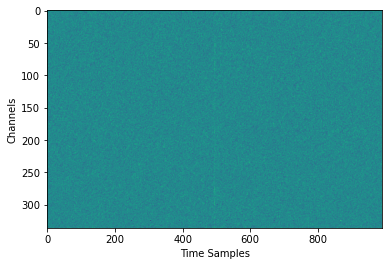

In [14]:
plt.imshow(detrend(cand.dedispersed.T), aspect="auto", interpolation=None)
plt.ylabel("Channels")
plt.xlabel("Time Samples")
plt.show()

We can have a look at the bandpass with and without [detrending](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html) .

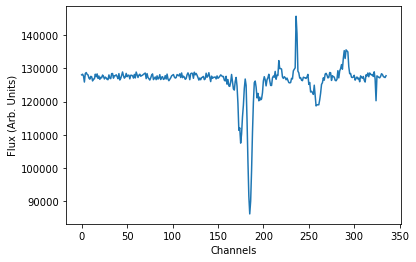

In [15]:
# Without detrend
plt.plot(cand.dedispersed.T.sum(1))
plt.xlabel("Channels")
plt.ylabel("Flux (Arb. Units)")
plt.show()

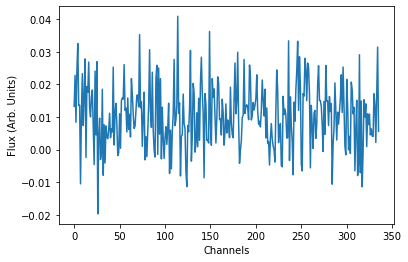

In [16]:
# With detrend
plt.plot(detrend(cand.dedispersed.T).sum(1))
plt.xlabel("Channels")
plt.ylabel("Flux (Arb. Units)")
plt.show()

## DM Optimization

Single pulse search pipelines often report approximate DMs. We can find the DM which maximizes our Signal to Noise Ratio (SNR) using the [`optimize_dm`](https://thepetabyteproject.github.io/your/candidate/#optimize_dm) method. We assume that the DM vs SNR curve is a convex function and use [`golden`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.golden.html) method to find the minima. The function returns optimal DM and SNR.

**Note** This is an experimental feature. 

In [17]:
cand.optimize_dm()
print(f"Heimdall reported dm: {cand.dm}, Optimised DM: {cand.dm_opt}")
print(f"Heimdall reported snr: {cand.snr}, SNR at Opt. DM: {cand.snr_opt}")

Heimdall reported dm: 475.284, Optimised DM: 474.7613272736851
Heimdall reported snr: 16.8128, SNR at Opt. DM: 14.077508926391602


## Saving the candidate

For now, let's enter `-1` as values for `dm_opt` and `snr_opt`

In [18]:
cand.dm_opt = -1
cand.snr_opt = -1

Each candiate gets a unique ID which can be accessed using `cand.id`

In [19]:
cand.id

'cand_tstart_58682.620316710374_tcand_2.0288800_dm_475.28400_snr_16.81280'

Now let's save our candidate in an HDF format file

In [20]:
fout = cand.save_h5()
print(fout)

2021-01-31 19:22:40,675 - your.candidate - MainThread - INFO - Saving h5 file cand_tstart_58682.620316710374_tcand_2.0288800_dm_475.28400_snr_16.81280.h5.


cand_tstart_58682.620316710374_tcand_2.0288800_dm_475.28400_snr_16.81280.h5


We will use [`plot_h5`](https://thepetabyteproject.github.io/your/utils/plotter/#plot_h5) function to plot the candidate HDF format file (or h5 file) we just generated.

2021-01-31 19:22:41,697 - root - MainThread - WARNING - Lengh of time axis is not 256. This data is probably not pre-processed.


<Figure size 432x288 with 0 Axes>

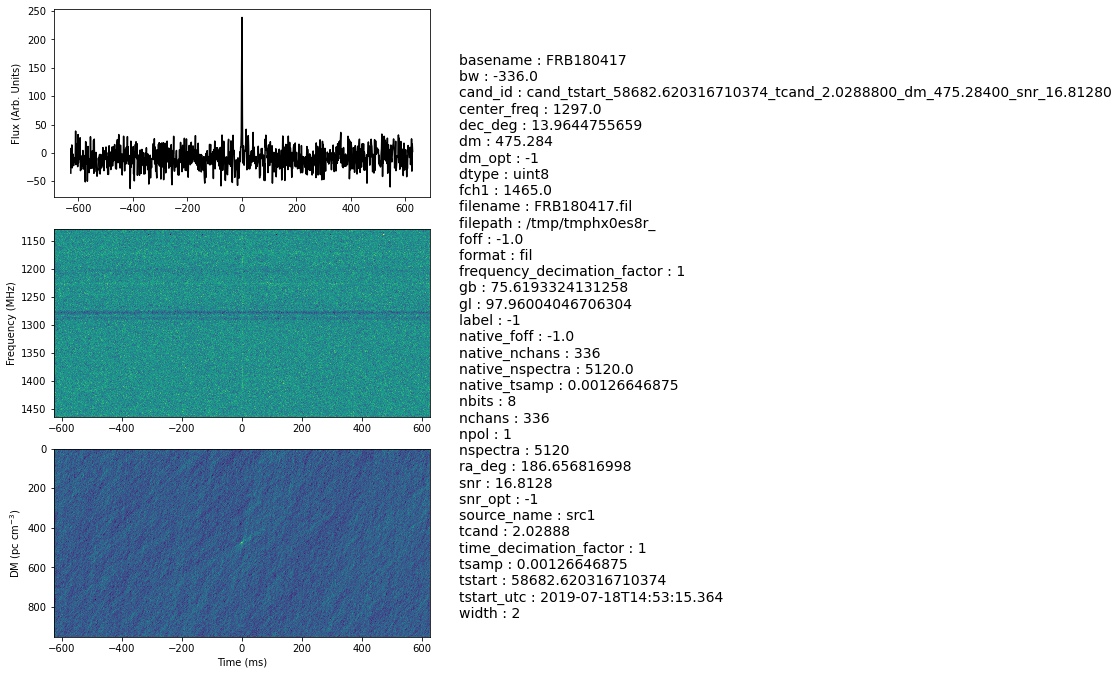

In [21]:
plot_h5(fout, detrend_ft=False, save=True)

We can also create publication quality plots right here using `publication=True` argument.

2021-01-31 19:22:44,245 - root - MainThread - WARNING - Lengh of time axis is not 256. This data is probably not pre-processed.


<Figure size 432x288 with 0 Axes>

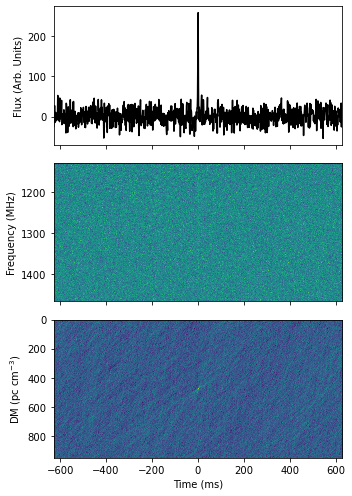

In [22]:
plot_h5(fout, detrend_ft=True, save=True, publication=True)

## Reshaping and Resizing

### Reshaping Freq-time and DM-time arrays

In [23]:
dedispersed_bkup = cand.dedispersed
dmt_bkup = cand.dmt

In [24]:
print(f"Shape of dedispersed (frequency-time) data: {dedispersed_bkup.T.shape}")
print(f"Shape of DM-time data: {dmt_bkup.shape}")

Shape of dedispersed (frequency-time) data: (336, 991)
Shape of DM-time data: (256, 991)


In [25]:
time_size = 256
freq_size = 256

### Using resize in skimage.transform for reshaping

In [26]:
# resize dedispersed Frequency-time array along frequency axis
print("Resizing time axis")
cand.resize(key="ft", size=time_size, axis=0, anti_aliasing=True)
print(
    f"Shape of dedispersed (frequency-time) data after resizing: {cand.dedispersed.T.shape}"
)

# resize dedispersed Frequency-time array along time axis
print("Resizing frequency axis")
cand.resize(key="ft", size=freq_size, axis=1, anti_aliasing=True)
print(
    f"Shape of dedispersed (frequency-time) data after resizing: {cand.dedispersed.T.shape}"
)

Resizing time axis
Shape of dedispersed (frequency-time) data after resizing: (336, 256)
Resizing frequency axis
Shape of dedispersed (frequency-time) data after resizing: (256, 256)


In [27]:
# resize DM-time array along time axis
cand.resize(key="dmt", size=time_size, axis=1, anti_aliasing=True)
print(f"Shape of DM-time data after resizing: {cand.dmt.shape}")

Shape of DM-time data after resizing: (256, 256)


### Using decimate for reshaping

In [28]:
from your.candidate import crop

In [29]:
cand.dedispersed = dedispersed_bkup
cand.dmt = dmt_bkup

In [30]:
print(f"Shape of dedispersed (frequency-time) data: {cand.dedispersed.T.shape}")

Shape of dedispersed (frequency-time) data: (336, 991)


In [31]:
# Let's use pulse width to decide the decimate factor by which to collape the time axis
pulse_width = cand.width
if pulse_width == 1:
    time_decimate_factor = 1
else:
    time_decimate_factor = pulse_width // 2

freq_decimation_factor = cand.dedispersed.shape[1] // freq_size
print(f"Time decimation factor is {time_decimate_factor}")
print(f"Frequency decimation factor is {freq_decimation_factor}")

Time decimation factor is 1
Frequency decimation factor is 1


Let's set the factors to something more interesting than 1

In [32]:
time_decimate_factor = 2
frequency_decimate_factor = 2

In [33]:
# Decimating time axis, and cropping to the final size
cand.decimate(
    key="ft", axis=0, pad=True, decimate_factor=time_decimate_factor, mode="median"
)
print(
    f"Shape of dedispersed (frequency-time) data after time decimation: {cand.dedispersed.T.shape}"
)

# Cropping the time axis to a required size
crop_start_sample_ft = cand.dedispersed.shape[0] // 2 - time_size // 2
cand.dedispersed = crop(cand.dedispersed, crop_start_sample_ft, time_size, 0)
print(
    f"Shape of dedispersed (frequency-time) data after time decimation + crop: {cand.dedispersed.T.shape}"
)

# Decimating frequency axis
cand.decimate(
    key="ft", axis=1, pad=True, decimate_factor=frequency_decimate_factor, mode="median"
)
print(
    f"Shape of dedispersed (frequency-time) data after decimation: {cand.dedispersed.T.shape}"
)

2021-01-31 19:22:45,710 - your.utils.misc - MainThread - INFO - padding along axis 0


Shape of dedispersed (frequency-time) data after time decimation: (336, 496)
Shape of dedispersed (frequency-time) data after time decimation + crop: (336, 256)
Shape of dedispersed (frequency-time) data after decimation: (168, 256)


In [34]:
# Reshaping the DM-time using decimation
# Decimating time axis and croppig to the final required size
print(f"Original shape of DM-time data after time decimation: {cand.dmt.shape}")
cand.decimate(
    key="dmt", axis=1, pad=True, decimate_factor=time_decimate_factor, mode="median"
)
print(f"Shape of DM-time data after time decimation: {cand.dmt.shape}")

crop_start_sample_dmt = cand.dmt.shape[1] // 2 - time_size // 2
cand.dmt = crop(cand.dmt, crop_start_sample_dmt, time_size, 1)

print(f"Shape of DM-time data after time decimation + crop: {cand.dmt.shape}")

2021-01-31 19:22:45,745 - your.utils.misc - MainThread - INFO - padding along axis 1


Original shape of DM-time data after time decimation: (256, 991)
Shape of DM-time data after time decimation: (256, 496)
Shape of DM-time data after time decimation + crop: (256, 256)


Let's take a final look at the data. Decimation reduces the standard deviation of the data so the candidates should look more significant now. 

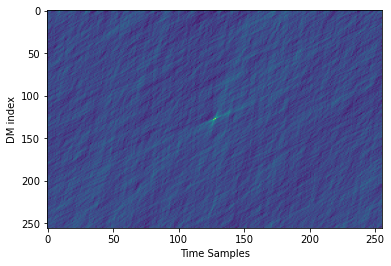

In [35]:
plt.imshow(cand.dmt, aspect="auto")
plt.ylabel("DM index")
plt.xlabel("Time Samples")
plt.show()

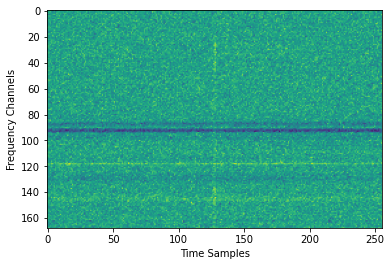

In [36]:
plt.imshow(cand.dedispersed.T, aspect="auto")
plt.ylabel("Frequency Channels")
plt.xlabel("Time Samples")
plt.show()

We can save this decimated data to HDF format files using the same command as before.

In [37]:
fout = cand.save_h5()
print(fout)

2021-01-31 19:22:46,153 - your.candidate - MainThread - INFO - Saving h5 file cand_tstart_58682.620316710374_tcand_2.0288800_dm_475.28400_snr_16.81280.h5.


cand_tstart_58682.620316710374_tcand_2.0288800_dm_475.28400_snr_16.81280.h5


<Figure size 432x288 with 0 Axes>

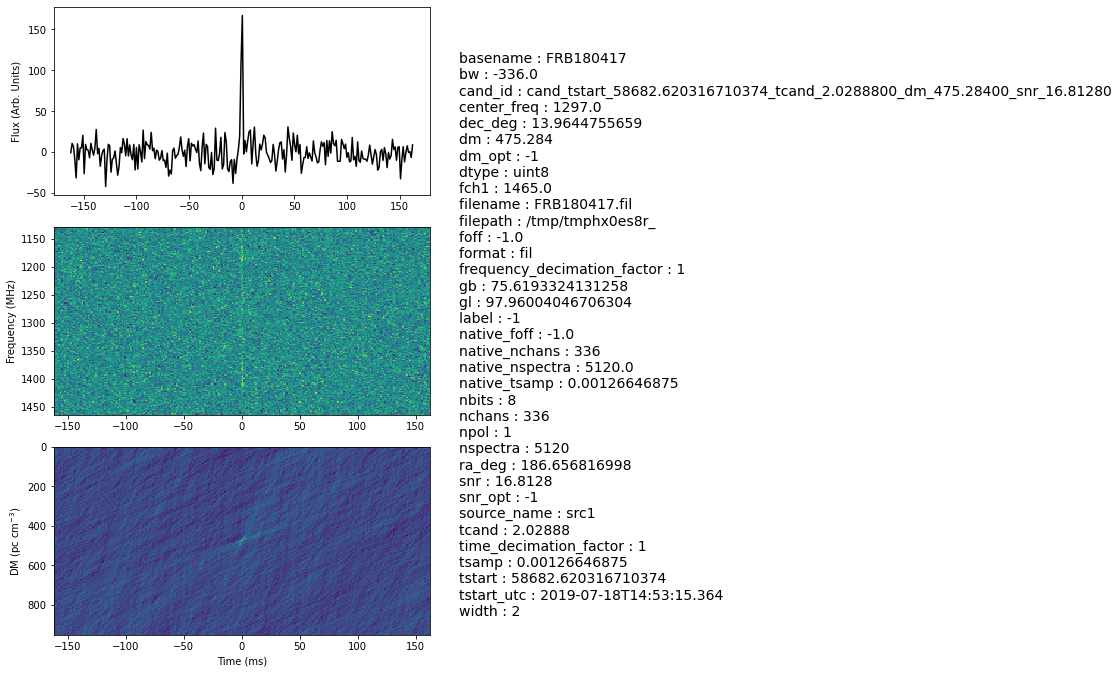

In [38]:
# Let's also detrend to remove the bandpass variations
plot_h5(fout, detrend_ft=True, save=True)